In [10]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import json

In [11]:
# Constants for preprocessing
csv_file = "pre_processed_reviews_svm.csv"
json_file = open('yelp_dataset/yelp_academic_dataset_review.json', 'r', encoding='utf-8')

# Step 1: Preprocessing JSON data and saving to CSV
def pre_process_json():
    object_count = 0
    for line in json_file:
        try:
            if object_count == 10000:
                break

            # Converting each JSON object into the valid JSON format
            data = json.loads(line)

            # Data Transformation
            stars = int(data['stars'])
            useful = int(data['useful'])
            funny = int(data['funny'])
            cool = int(data['cool'])
            text = str(data['text'])

            # Feature extraction
            neutral = funny + cool

            if useful == 0 or funny == 0 or cool == 0:
                continue
            else:
                sentiment_list = [useful, neutral]
                sentiment = sentiment_list.index(max(sentiment_list))
                if stars >= 3 and sentiment == 0:
                    reaction = 'satisfied considerable comment'
                elif stars >= 3 and sentiment == 1:
                    reaction = 'satisfied neutral comment'
                elif stars < 3 and sentiment == 0:
                    reaction = 'unsatisfied considerable comment'
                elif stars < 3 and sentiment == 1:
                    reaction = 'unsatisfied neutral comment'

            data = {'text': [text], 'Sentiment': [reaction]}
            df = pd.DataFrame(data)

            # Append the data to the CSV file
            if object_count == 0:
                df.to_csv(csv_file, index=False)
            else:
                df.to_csv(csv_file, mode='a', header=False, index=False)

            object_count += 1

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

# Call the preprocessing function
pre_process_json()
json_file.close()

# Load the processed data to verify
processed_data = pd.read_csv(csv_file)
print(processed_data.head())


                                                text  \
0  I am a long term frequent customer of this est...   
1  HOLY SMOKES!\n\nactual pumpkin pie mixed in wi...   
2  I thoroughly enjoyed the show.  Chill way to s...   
3  On a scale of one to things that are awesome, ...   
4  I've only had the cannolis here but they are a...   

                        Sentiment  
0     unsatisfied neutral comment  
1       satisfied neutral comment  
2       satisfied neutral comment  
3  satisfied considerable comment  
4       satisfied neutral comment  


In [12]:
# Step 2: Load preprocessed data
data = pd.read_csv(csv_file)
X = data['text']
y = data['Sentiment']

data

,text,Sentiment
0,I am a long term frequent customer of this est...,unsatisfied neutral comment
1,HOLY SMOKES!\n\nactual pumpkin pie mixed in wi...,satisfied neutral comment
2,I thoroughly enjoyed the show. Chill way to s...,satisfied neutral comment
3,"On a scale of one to things that are awesome, ...",satisfied considerable comment
4,I've only had the cannolis here but they are a...,satisfied neutral comment
...,...,...
9995,Was told about magic dragon vapors by a friend...,satisfied considerable comment
9996,"Chill on the Hill just opened, and it's a welc...",satisfied considerable comment
9997,"I've always liked TBBC, but it's a bit of a ha...",satisfied neutral comment
9998,I seriously cannot stress how incredible this ...,satisfied considerable comment


In [13]:
X

0       I am a long term frequent customer of this est...
1       HOLY SMOKES!\n\nactual pumpkin pie mixed in wi...
2       I thoroughly enjoyed the show.  Chill way to s...
3       On a scale of one to things that are awesome, ...
4       I've only had the cannolis here but they are a...
                              ...                        
9995    Was told about magic dragon vapors by a friend...
9996    Chill on the Hill just opened, and it's a welc...
9997    I've always liked TBBC, but it's a bit of a ha...
9998    I seriously cannot stress how incredible this ...
9999    My second visit here was a couple of months ag...
Name: text, Length: 10000, dtype: object

In [14]:
y

0          unsatisfied neutral comment
1            satisfied neutral comment
2            satisfied neutral comment
3       satisfied considerable comment
4            satisfied neutral comment
                     ...              
9995    satisfied considerable comment
9996    satisfied considerable comment
9997         satisfied neutral comment
9998    satisfied considerable comment
9999         satisfied neutral comment
Name: Sentiment, Length: 10000, dtype: object

In [15]:
# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features for better performance
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Step 5: Train SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)  # Linear kernel for text classification
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

In [18]:
# Step 6: Evaluate the SVM model
y_pred = svm_model.predict(X_test_tfidf)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


SVM Model Accuracy: 57.30%

Classification Report:
                                   precision    recall  f1-score   support

  satisfied considerable comment       0.43      0.16      0.24       574
       satisfied neutral comment       0.61      0.90      0.72      1050
unsatisfied considerable comment       0.52      0.34      0.41       199
     unsatisfied neutral comment       0.44      0.25      0.32       177

                        accuracy                           0.57      2000
                       macro avg       0.50      0.41      0.42      2000
                    weighted avg       0.53      0.57      0.52      2000



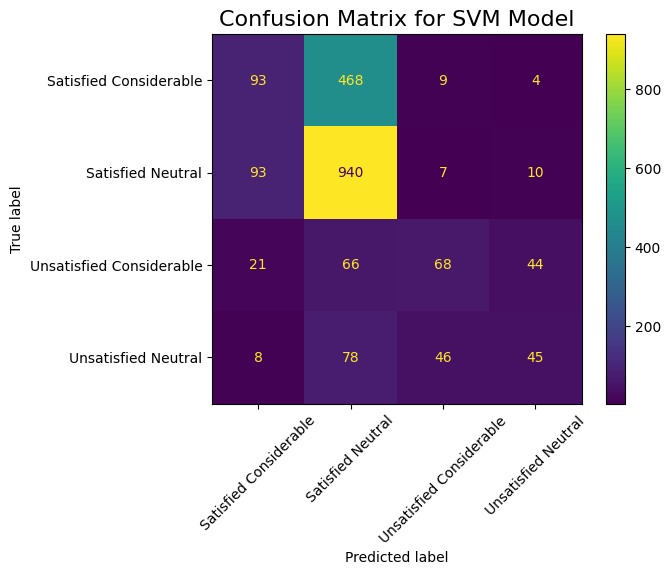

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['satisfied considerable comment', 'satisfied neutral comment', 
                                               'unsatisfied considerable comment', 'unsatisfied neutral comment'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Satisfied Considerable', 'Satisfied Neutral', 
                                                                    'Unsatisfied Considerable', 'Unsatisfied Neutral'])
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix for SVM Model", fontsize=16)
plt.show()


/var/folders/zz/vz7cvvnd5ws3182279mslrc80000gn/T/ipykernel_57439/2690095280.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y, palette="viridis")


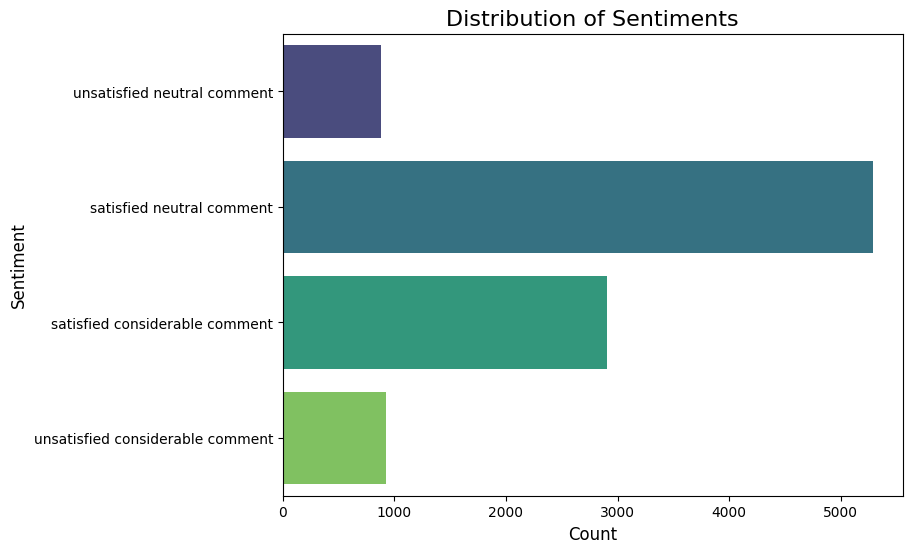

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(y, palette="viridis")
plt.title("Distribution of Sentiments", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Sentiment", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [17]:
# # Step 7: Save vectorizer and model for future use
# import joblib

# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(svm_model, 'svm_sentiment_model.pkl')

# print("Model and vectorizer saved successfully.")